### Forecast de demanda: Facturapp

#### ✅ ARIMA

1) Datos

In [89]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

In [90]:
import pandas as pd

# Rutas a los archivos CSV
clientes_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecasting_for_planning/csv/clientes.csv'
productos_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecasting_for_planning/csv/productos.csv'
ventas_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecasting_for_planning/csv/ventas.csv'

# Leer los archivos CSV
clientes_df = pd.read_csv(clientes_path)
productos_df = pd.read_csv(productos_path)
ventas_df = pd.read_csv(ventas_path)

In [91]:
# Asegúrate de que 'monto_ventas_producto' sea numérico
ventas_df['monto_ventas_producto'] = pd.to_numeric(ventas_df['cantidad_ventas_producto'], errors='coerce')

# Agrupa por tipo de moneda y suma los montos de ventas
suma_por_moneda = ventas_df.groupby('moneda_venta')['cantidad_ventas_producto'].sum()

# Calcular el total de todas las ventas
total_ventas = suma_por_moneda.sum()

# Crear un nuevo DataFrame con los montos y los porcentajes
resultado = pd.DataFrame({
    'Monto Total': suma_por_moneda,
    'Porcentaje del Total': (suma_por_moneda / total_ventas) * 100
})

# Formatear los montos y porcentajes para mejor legibilidad
resultado['Monto Total'] = resultado['Monto Total'].apply(lambda x: f"{x:,.2f}")
resultado['Porcentaje del Total'] = resultado['Porcentaje del Total'].apply(lambda x: f"{x:.2f}%")

# Verificar el resultado
resultado

,Monto Total,Porcentaje del Total
moneda_venta,,
$,"1,460,236.00",99.99%
U$S,140.00,0.01%


In [92]:
# Filtrar por tipo de moneda (por ejemplo, solo $)
ventas_filtrado = ventas_df.loc[ventas_df['moneda_venta'] == '$  ']

# Crear la tabla agregada con el DataFrame filtrado
df = ventas_filtrado.groupby('fecha_venta').agg(
    cantidad_ventas_producto=pd.NamedAgg(column='cantidad_ventas_producto', aggfunc='sum')
).reset_index()

# Renombramos variables para que Prophet tome como input
df = df.rename(columns={'fecha_venta': 'ds', 'cantidad_ventas_producto': 'y'})

# Asegurarse de que 'ds' sea un datetime
df['ds'] = pd.to_datetime(df['ds'])

# Revisar los datos resampleados
df.head(20)

,ds,y
0,2022-04-16,39.000
1,2022-04-17,165.640
2,2022-04-18,2235.130
3,2022-04-19,1167.624
4,2022-04-20,1734.857
5,2022-04-21,1071.296
6,2022-04-22,1497.522
7,2022-04-23,857.400
8,2022-04-24,8.000
9,2022-04-25,977.481


#### ARIMA

Datos de training:  550  -  82.0 %
Datos de testing:  119  -  18.0 %


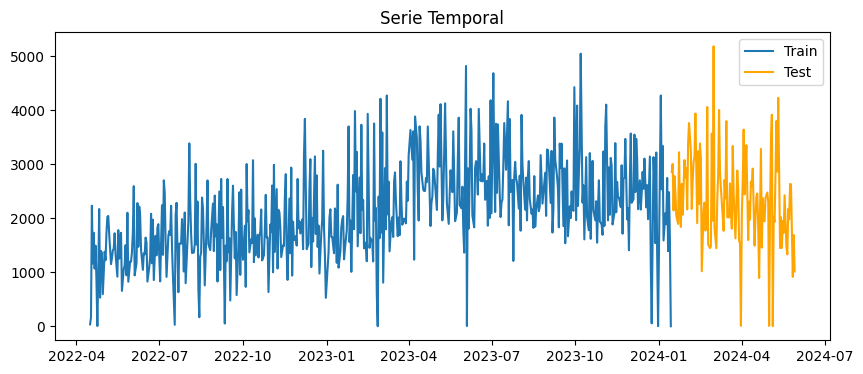

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Separación de datos
TEST_DATE = '2024-01-15'
df_train = df[df['ds'] < TEST_DATE]
df_test = df[df['ds'] >= TEST_DATE]

print("Datos de training: ", len(df_train), " - ", round((len(df_train)/len(df)),2)*100, "%")
print("Datos de testing: ", len(df_test), " - ", round((len(df_test)/len(df)),2)*100, "%")

# Plot serie temporal
plt.figure(figsize=(10, 4))
plt.plot(df_train['ds'], df_train['y'], label='Train')
plt.plot(df_test['ds'], df_test['y'], label='Test', color='orange')
plt.legend()
plt.title("Serie Temporal")
plt.show()

##### Prueba de estacionariedad con ADF

Realizamos la prueba Augmented Dickey-Fuller para verificar si la serie es estacionaria.

In [94]:
# Prueba de estacionariedad ADF
result = adfuller(df_train['y'])
print("p-value:", result[1])

# Si no es estacionaria, aplicar diferenciación
df_train_diff = df_train['y'].diff().dropna()

# Verificar de nuevo
result_diff = adfuller(df_train_diff)
print("p-value (differenced):", result_diff[1])

p-value: 0.15758583630208334
p-value (differenced): 3.1736492668764306e-15


##### Análisis ACF y PACF

Generamos gráficos de ACF y PACF para identificar valores preliminares de p y q.

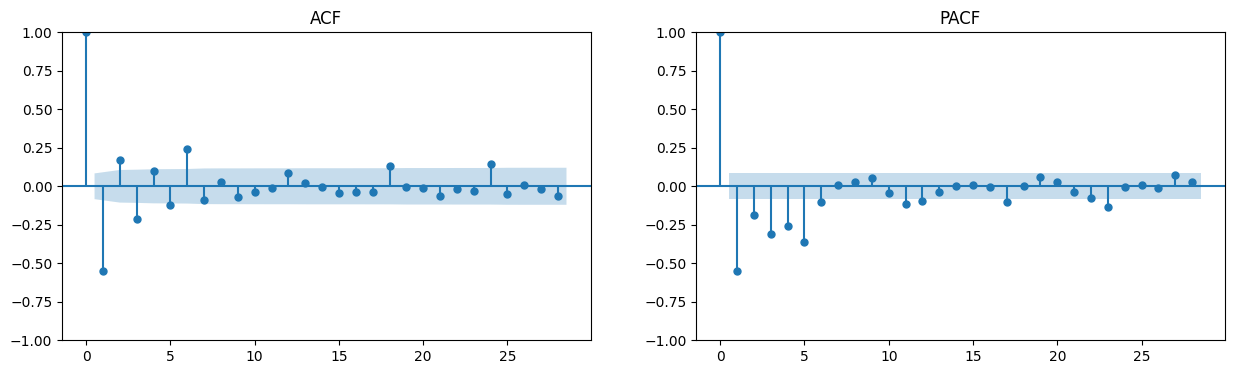

In [95]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(df_train_diff, ax=axes[0], title='ACF')
plot_pacf(df_train_diff, ax=axes[1], title='PACF')
plt.show()

##### Búsqueda de parámetros óptimos

Utilizamos auto_arima para encontrar los parámetros óptimos.

In [96]:
# Auto ARIMA
stepwise_fit = auto_arima(df_train['y'], 
                          seasonal=False, 
                          trace=True,
                          suppress_warnings=True)

print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8825.237, Time=1.00 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9212.655, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9016.866, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8833.293, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9210.656, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8824.257, Time=0.77 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8833.373, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8833.247, Time=0.35 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8824.929, Time=0.75 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=8835.078, Time=0.90 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8834.302, Time=0.78 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=8799.177, Time=0.89 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=8778.173, Time=1.53 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=8815.305, Time=0.96 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept

##### Ajuste del modelo ARIMA

Ajustamos el modelo ARIMA con los parámetros encontrados.

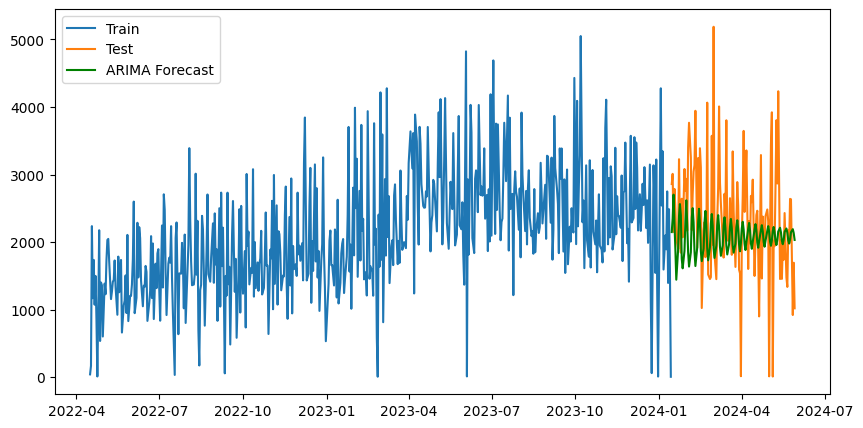

In [97]:
# Parámetros obtenidos de auto_arima
p, d, q = stepwise_fit.order

# Ajustar ARIMA
model = sm.tsa.ARIMA(df_train['y'], order=(p, d, q))
results = model.fit()

# Predicción
forecast = results.forecast(steps=len(df_test))
df_test['forecast'] = forecast

# Visualización de predicciones
plt.figure(figsize=(10, 5))
plt.plot(df_train['ds'], df_train['y'], label='Train')
plt.plot(df_test['ds'], df_test['y'], label='Test')
plt.plot(df_test['ds'], df_test['forecast'], label='ARIMA Forecast', color='green')
plt.legend()
plt.show()


##### Métricas de evaluación

In [101]:
# Cálculo de todas las métricas
mae = mean_absolute_error(df_test['y'], df_test['forecast'])
rmse = np.sqrt(mean_squared_error(df_test['y'], df_test['forecast']))
mse = mean_squared_error(df_test['y'], df_test['forecast'])
mape = np.mean(np.abs((df_test['y'] - df_test['forecast']) / df_test['y'])) * 100

print("=== Métricas de Evaluación ===")
print(f"MAE (Error Absoluto Medio): {mae:.2f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.2f}")
print(f"MSE (Error Cuadrático Medio): {mse:.2f}")
print(f"MAPE (Error Porcentual Absoluto Medio): {mape:.2f}%")

=== Métricas de Evaluación ===
MAE (Error Absoluto Medio): 691.14
RMSE (Raíz del Error Cuadrático Medio): 932.64
MSE (Error Cuadrático Medio): 869817.56
MAPE (Error Porcentual Absoluto Medio): 601.17%
